# How to train an ontology-based variational autoencoder (Ontix)

In normal autoencoders latent dimensions are not explainable by design. To gain explainability and to incorporate biological information, a popular approach is to restrict the decoder of the autoencoder to match feature connectivity like an ontology. 

In this notebook we will show two types of ontologies and how they can be used to train an explainable variational autoencoder `ontix`. 
The first is based on biological pathways of the Reactome database (left) and the second uses chromosomal location of genes (right) as a showcase. 

<img src="https://raw.githubusercontent.com/jan-forest/autoencodix/5dabc4a697cbba74d3f6144dc4b6d0fd6df2b624/images/ontix_scheme.svg" alt="ontix-ontologies" width="1200"/>

## Set-up your ontology

The only thing you need to do to train an `ontix` is to provide text files for up to two ontology levels. The first ontology level is the mapping of your features (e.g. Gene ID) and an ontology level like subpathways or cytobands of chromosome. The second level is optional, but recommended, and is the mapping of the first ontology to a second level like top-level pathways or chromosome. 

The mapping should have the format:  
Gene 1 `separator` Pathway1  
Gene 2 `separator` Pathway1  
Gene 3 `separator` Pathway2  
..

By default the `separator` is defined as tabular via `DELIM:"\t"` in the `src/000_internal_config.yaml`

### Example 1: Set-up chromosomal ontology
From Ensembl via Biomart or any other sequence database you can get cytoband (karyotype) and chromosomal information for human genes like this:

In [1]:
import pandas as pd

df_genes = pd.read_csv("genes_chromosomes.txt", sep="\t" )
df_genes

,Gene stable ID,Gene stable ID version,Karyotype band,Chromosome/scaffold name,Gene start (bp),Gene end (bp),HGNC symbol,NCBI gene (formerly Entrezgene) ID
0,ENSG00000198888,ENSG00000198888.2,NaN,MT,3307,4262,MT-ND1,4535
1,ENSG00000198763,ENSG00000198763.3,NaN,MT,4470,5511,MT-ND2,4536
2,ENSG00000198804,ENSG00000198804.2,NaN,MT,5904,7445,MT-CO1,4512
3,ENSG00000210151,ENSG00000210151.2,NaN,MT,7446,7514,MT-TS1,113219467
4,ENSG00000198712,ENSG00000198712.1,NaN,MT,7586,8269,MT-CO2,4513
...,...,...,...,...,...,...,...,...
35852,ENSG00000290825,ENSG00000290825.1,p36.33,1,11869,14409,NaN,102725121
35853,ENSG00000290825,ENSG00000290825.1,p36.33,1,11869,14409,NaN,100287596
35854,ENSG00000290825,ENSG00000290825.1,p36.33,1,11869,14409,NaN,100287102
35855,ENSG00000290825,ENSG00000290825.1,p36.33,1,11869,14409,NaN,727856


We have to solve some issues before we can use this as ontology.  
(1) We only want chromosomes and not scaffolds  
(2) Karyotype/cytoband should have identification of the chromosome in their name as identifier

In [2]:
df_genes = df_genes.loc[ df_genes['Chromosome/scaffold name'].str.len() < 3] ## get rid of scaffolds and keep only chromosomes
df_genes.loc[df_genes['Chromosome/scaffold name'] == "MT", 'Karyotype band'] = 'MT' ## create missing karyotype for mito genes
print("This will be our chromosomes and latent dimensions in Ontix:")
print(df_genes['Chromosome/scaffold name'].unique())
print(f"Latent dimension: {len(df_genes['Chromosome/scaffold name'].unique())}")

This will be our chromosomes and latent dimensions in Ontix:
['MT' 'Y' '21' '13' '18' '22' '20' 'X' '15' '14' '10' '9' '8' '16' '4' '5'
 '7' '6' '19' '12' '11' '3' '17' '2' '1']
Latent dimension: 25


In [5]:
# Combine Chromosome name and cytoband
df_genes.loc[:,'Chr_and_karyotype'] = df_genes[['Chromosome/scaffold name','Karyotype band']].apply(lambda x: ':'.join(x.values.tolist()), axis=1)
print("This will be our hidden layer in the sparse decoder:")
print(df_genes['Chr_and_karyotype'].unique()[0:20])
print(f"Hidden layer dim: {len(df_genes['Chr_and_karyotype'].unique())}")

This will be our hidden layer in the sparse decoder:
['MT:MT' 'Y:p11.2' 'Y:q11.223' 'Y:q11.221' 'Y:q11.222' 'Y:q11.23'
 'Y:p11.31' 'Y:p11.32' 'Y:q12' '21:p12' '21:q21.1' '21:q21.2' '21:p11.2'
 '13:q12.12' '21:q21.3' '21:q22.11' '13:q12.3' '13:q14.12' '13:q14.2'
 '21:q22.12']
Hidden layer dim: 817


Now we can save this as files in the correct format for the two levels

In [6]:
# Level 1
df_genes[
	['NCBI gene (formerly Entrezgene) ID','Chr_and_karyotype']	# Level 1: Feature (gene) to hidden layer (cytoband)
	].drop_duplicates(											# Chromosomal ontology must be unique
	).to_csv("../../data/raw/chromosome_ont_lvl1_ncbi.txt", sep="\t", header=False, index=False )	# Save under data/raw

# Level 2
df_genes[
	['Chr_and_karyotype','Chromosome/scaffold name']			# Level 2: hidden layer (cytoband) to latent dimension (chromosome)
	].drop_duplicates(											# Chromosomal ontology must be unique
	).to_csv("../../data/raw/chromosome_ont_lvl2_ncbi.txt", sep="\t", header=False, index=False )	# Save under data/raw

## Create your config 
This is very much similar to a normal VAE `varix` as shown in the `Basics_Autoencodix.ipynb` tutorial. With the following adjustments and additions:  
(1) set `MODEL_TYPE` to `ontix`  
(2) specify ontologies files under `FILE_ONT_LVL1` and `FILE_ONT_LVL1`  
(3) specify number of layers after ontology layers in the decoder. We set this to `NON_ONT_LAYER:0` since we want no additional dimension reduction by additional layers upon the ontology.

In [1]:
## We will use Python for config defintion, but you can write your own yaml-config with an editor
import yaml
cfg = dict()
# Ontix specific
cfg['MODEL_TYPE'] = "ontix" 
cfg['FILE_ONT_LVL1'] = "chromosome_ont_lvl1_ncbi.txt"
cfg['FILE_ONT_LVL2'] = "chromosome_ont_lvl2.txt"
cfg['NON_ONT_LAYER'] = 0

# DATA DEFINITIONS ------------------------------------------------------------
# -----------------------------------------------------------------------------
cfg['DATA_TYPE'] = dict()
# RNAseq
cfg['DATA_TYPE']['RNA'] = dict()
cfg['DATA_TYPE']['RNA']['SCALING'] = "Standard"	# We scale features by the standard scaler
cfg['DATA_TYPE']['RNA']['TYPE'] = "NUMERIC"
cfg['DATA_TYPE']['RNA']['FILTERING'] = "Var"	# We filter for feature with highest variance
cfg['DATA_TYPE']['RNA']['FILE_RAW'] = "stad_rnaseq_formatted.parquet"
# METH
cfg['DATA_TYPE']['METH'] = dict()
cfg['DATA_TYPE']['METH']['SCALING'] = "Standard"
cfg['DATA_TYPE']['METH']['TYPE'] = "NUMERIC"
cfg['DATA_TYPE']['METH']['FILTERING'] = "Var"
cfg['DATA_TYPE']['METH']['FILE_RAW'] = "stad_meth_formatted.parquet"
# Clinical Parameters for plotting
cfg['DATA_TYPE']['ANNO'] = dict()
cfg['DATA_TYPE']['ANNO']['TYPE'] = "ANNOTATION"
cfg['DATA_TYPE']['ANNO']['FILE_RAW'] = "stad_clin_formatted.parquet"

## Model and Training --------------------------------------------------------
# ----------------------------------------------------------------------------
# Reproducibility
cfg['FIX_RANDOMNESS'] = "all"
cfg['GLOBAL_SEED'] = 42
# Model
cfg['TRAIN_TYPE'] = "train" # simple training, no tuning
cfg['RECONSTR_LOSS'] = "MSE"	# loss function for reconstruction
cfg['VAE_LOSS'] = "KL"		# loss function distribution distance
cfg['BETA'] = 0.1			# weighting of VAE loss
cfg['K_FILTER'] = 500		# Input features per data modality
cfg["LATENT_DIM_FIXED"] = 6	# Latent space dimension
# Training
cfg['EPOCHS'] = 1000
cfg['LR_FIXED'] = 0.0005	# Learning rate
cfg['BATCH_SIZE'] = 32
cfg['DROP_P'] = 0.9			# We have a small number of samples and should be aggressive with drop out to avoid overfitting
# Prediction
cfg['PREDICT_SPLIT'] = "all"	# Embedding of all samples should be calculated in prediction
# EVALUATION and VISUALIZATION ------------------------------------------------
# -----------------------------------------------------------------------------
cfg['DIM_RED_METH'] = "UMAP"	# For 2D visualization when LATENT_DIM_FIXED>2
cfg['CLINIC_PARAM'] = [			# Parameters to colorize plots and perform embedding evaluation
				"SUBTYPE",
				"AJCC_PATHOLOGIC_TUMOR_STAGE",
				"TMB_NONSYNONYMOUS",
				"AGE",
				"SEX",
				"ONCOTREE_CODE",
				"GRADE",
				"PATH_N_STAGE",
				"DSS_STATUS",
				"OS_STATUS"
			]
cfg['ML_TYPE'] = "Auto-detect"	# Is CLINIC_PARAM prediction either regression or classification?
cfg['ML_ALG'] = [				# ML algorithms for embedding evaluation
	'Linear',
	'RF'
	]
cfg['ML_SPLIT'] = "use-split"	# Test ML performance on train, test, valid split
cfg['ML_TASKS'] = [				# Compare embeddings to other dimension reduction methods
	'Latent',
	'UMAP',
	'PCA',
	'RandomFeature'
]


## save config
with open("../../"+"STAD-Chr-Ontix_config.yaml", 'w') as file:
	yaml.dump(cfg, file)

## Train and visualize the `ontix`


In [2]:
# Make sure to start from project root folder
%cd ../.. 
# Activate venv
!source venv-gallia/bin/activate
# Start pipeline
!make visualize RUN_ID=STAD-Chr-Ontix

/home/ewald/Gitlab/autoencodix/autoencoder
done config
2024-08-09 15:30:01,603 - src.utils.utils_basic - INFO - Unify sample ID list from data files
2024-08-09 15:30:02,985 - src.utils.utils_basic - INFO - Save sample split.
2024-08-09 15:30:02,989 - src.utils.utils_basic - INFO - Unified sample ID list has length 412
2024-08-09 15:30:02,990 - src.utils.utils_basic - INFO - Make data set ANNO
2024-08-09 15:30:03,018 - src.utils.utils_basic - INFO - Save ANNOTATION without preprocessing
2024-08-09 15:30:03,024 - src.utils.utils_basic - INFO - Make data set METH
2024-08-09 15:30:03,441 - src.utils.utils_basic - INFO - Select for samples and drop features with NA
2024-08-09 15:30:03,480 - src.utils.utils_basic - INFO - Preprocessing of ontology files
2024-08-09 15:30:04,284 - src.utils.utils_basic - WARNING - Number of features not in ontology file: 51
2024-08-09 15:30:04,285 - src.utils.utils_basic - WARNING - Dropping features not in ontology.
2024-08-09 15:30:04,295 - src.utils.utils_b

### Gaining insights by explainable latent dimensions and visualizations
The idea behind chromosomal location of features (genes) as an ontology for `ontix` that we can expect male and female patients to be separated on the `Y` and `X` chromosome.  
Let`s have a look if this is the case:  

Latent intensitiy plot grouped by  female/male patients


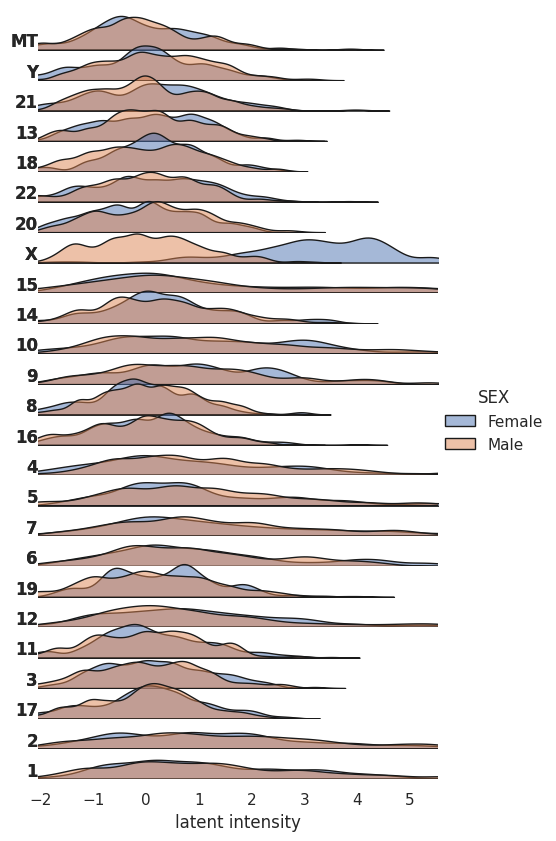

In [3]:
from IPython.display import Image
from IPython.display import display

ridgeline_chr = Image(filename='reports/STAD-Chr-Ontix/figures/latent_dist_SEX.png', width=600)

print("Latent intensitiy plot grouped by  female/male patients")
display(ridgeline_chr)

Indeed it is for the `X` chromosome. However, not for the `Y`.  
This is related to the fact that it is much smaller than other chromosomes and very few genes are located on `Y`.  
Hence, those genes and latent dimension has only very little impact on minimizing the loss function and a potential signal is not visible. 

## Using Reactome pathways as ontology
Chromosomal location as ontology is mostly a proof of concept as shown above how to gain explainability of latent dimensions.  
In practice, something like biological pathways or gene ontology is most commonly used to gain biological insights. 

### Get the reactome ontology and adjust the config

In [11]:
## We provide already pre-formatted files 
!echo "Level 1 file"
!head ./Tutorials/full_ont_lvl1_reactome.txt
!echo "Level 2 file"
!head ./Tutorials/full_ont_lvl2_reactome.txt
## Copy to data/raw
!cp ./Tutorials/full_ont*.txt data/raw/


Level 1 file


1	R-HSA-168249
100049587	R-HSA-168249
10006	R-HSA-168249
10006	R-HSA-168249
10010	R-HSA-168249
100132285	R-HSA-168249
100133267	R-HSA-168249
100289462	R-HSA-168249
100293534	R-HSA-168249
100302736	R-HSA-168249
Level 2 file
R-HSA-140837	R-HSA-109582
R-HSA-418346	R-HSA-109582
R-HSA-392851	R-HSA-109582
R-HSA-76005	R-HSA-109582
R-HSA-210993	R-HSA-109582
R-HSA-983189	R-HSA-109582
R-HSA-76002	R-HSA-109582
R-HSA-983231	R-HSA-109582
R-HSA-114604	R-HSA-109582
R-HSA-210990	R-HSA-109582


In [4]:
## We copy the previous config as template
!cp STAD-Chr-Ontix_config.yaml STAD-Rea-Ontix_config.yaml
## Change the ontology files to Reactome pathways in the copied config
!sed -i "s/FILE_ONT_LVL1\: chromosome_ont_lvl1_ncbi.txt/FILE_ONT_LVL1\: full_ont_lvl1_reactome.txt/g " STAD-Rea-Ontix_config.yaml
!sed -i "s/FILE_ONT_LVL2\: chromosome_ont_lvl2.txt/FILE_ONT_LVL2\: full_ont_lvl2_reactome.txt/g " STAD-Rea-Ontix_config.yaml

## Train and visualize the Reactome-based `ontix`

In [5]:
!make visualize RUN_ID=STAD-Rea-Ontix

done config
2024-08-09 15:35:33,004 - src.utils.utils_basic - INFO - Unify sample ID list from data files
2024-08-09 15:35:34,146 - src.utils.utils_basic - INFO - Save sample split.
2024-08-09 15:35:34,151 - src.utils.utils_basic - INFO - Unified sample ID list has length 412
2024-08-09 15:35:34,151 - src.utils.utils_basic - INFO - Make data set ANNO
2024-08-09 15:35:34,175 - src.utils.utils_basic - INFO - Save ANNOTATION without preprocessing
2024-08-09 15:35:34,181 - src.utils.utils_basic - INFO - Make data set METH
2024-08-09 15:35:34,570 - src.utils.utils_basic - INFO - Select for samples and drop features with NA
2024-08-09 15:35:34,597 - src.utils.utils_basic - INFO - Preprocessing of ontology files
2024-08-09 15:35:37,441 - src.utils.utils_basic - WARNING - Number of features not in ontology file: 4002
2024-08-09 15:35:37,441 - src.utils.utils_basic - WARNING - Dropping features not in ontology.
2024-08-09 15:35:37,447 - src.utils.utils_basic - INFO - Filter data: METH
2024-08-0

Now we can check which Reactome top-level pathways (latent dimensions) are associated with clinical parameters.  
Let's start with male/female again. 

Latent intensitiy plot grouped by  female/male patients


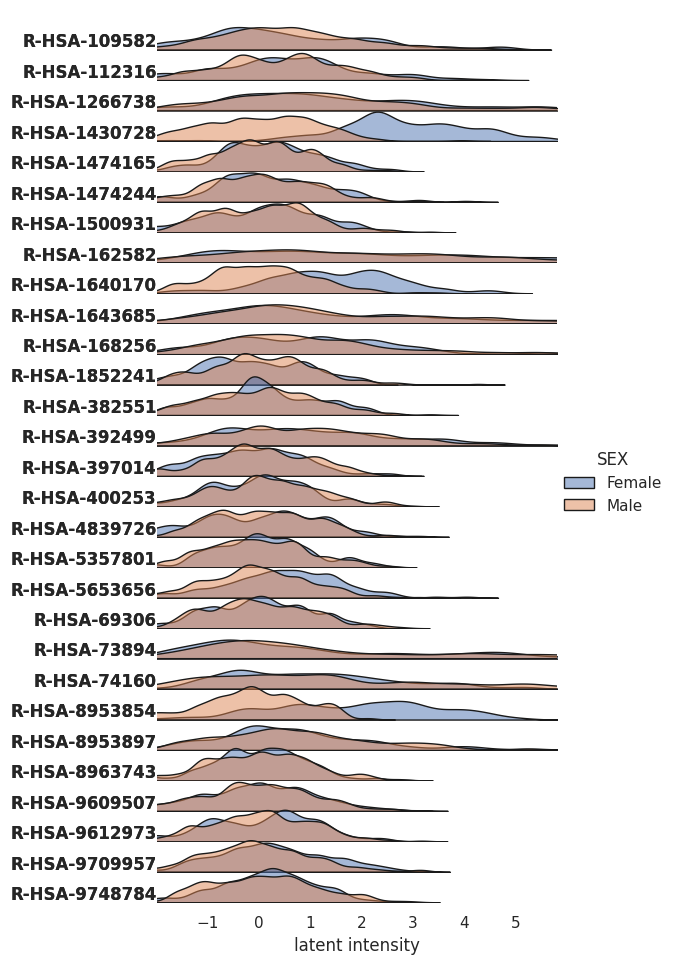

In [6]:
ridgeline_rea1 = Image(filename='reports/STAD-Rea-Ontix/figures/latent_dist_SEX.png', width=600)

print("Latent intensitiy plot grouped by  female/male patients")
display(ridgeline_rea1)

We see that multiple pathways are associated with differences in male and female patients.  
How are our gastric cancer subtypes associated with pathways?

Latent intensitiy plot grouped by cancer subtype


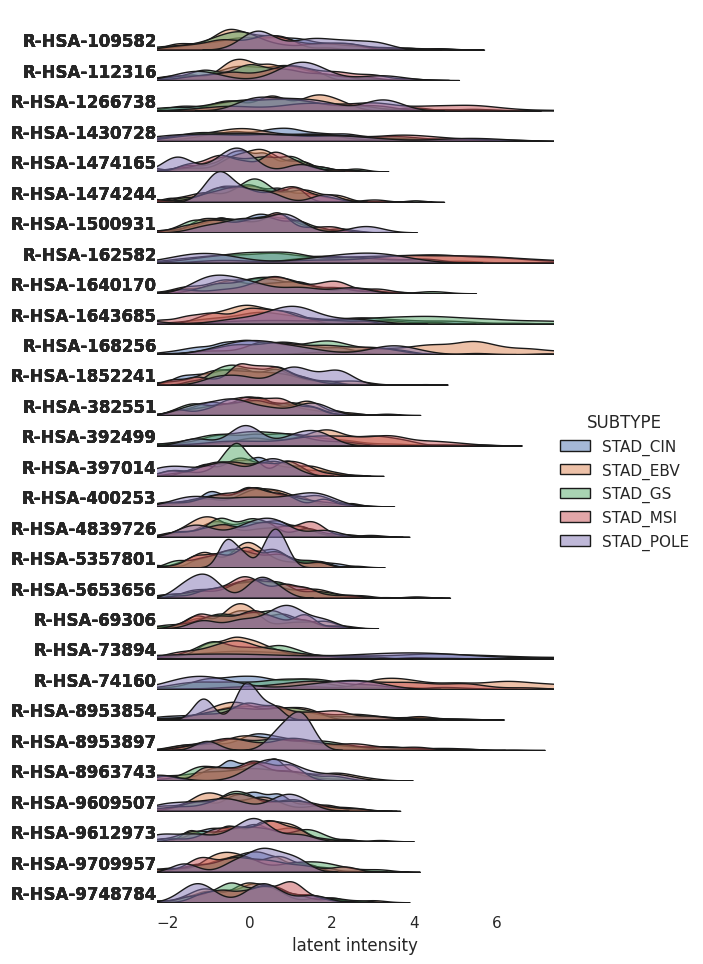

In [7]:
ridgeline_rea2 = Image(filename='reports/STAD-Rea-Ontix/figures/latent_dist_SUBTYPE.png', width=600)

print("Latent intensitiy plot grouped by cancer subtype")
display(ridgeline_rea2)

Interestingly, the stomach adenocarcinoma subtype EBV-positive (Ebstein-Barr-Virus) is clearly distinct from other patients in the top-level pathway `R-HSA-168256` (Immune system).  
We can also have a look if tumor grades are associated with differences in pathways.

Latent intensitiy plot grouped by tumor grade


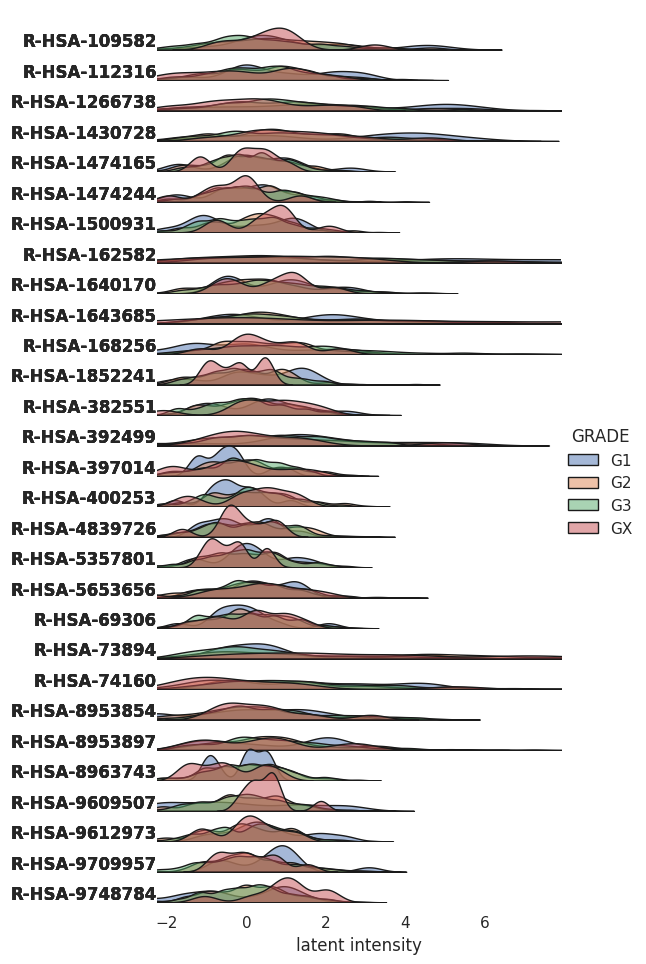

In [8]:
ridgeline_rea3 = Image(filename='reports/STAD-Rea-Ontix/figures/latent_dist_GRADE.png', width=600)

print("Latent intensitiy plot grouped by tumor grade")
display(ridgeline_rea3)

Tumor grade are mostly not seperated and associated well with top-level pathways but `G1` tumors are distinct e.g. in the pathway `R-HSA-1430728` (Metabolism).  
However, we strongly recommend to check for the robustness of such results by training multiple times with `FIX_RANDOMNESS:"random"` and compare results.  
As shown in our publication, typically not all latent dimensions are robust and is influenced by hyperparameters like `BETA` or `LR_FIXED`.